# Markov Process

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from sklearn.utils.class_weight import compute_sample_weight
import seaborn as sns
import joblib
import os

In [2]:
df = pd.read_csv(r'Data\fannie_cleaned.csv')

C:\Users\samvi\AppData\Local\Temp\ipykernel_36192\2984769409.py:1: DtypeWarning: Columns (12,19,26,29,32,33,34,35,36,37,38,39,40,46,49,51,53,54,55,56,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'Data\fannie_cleaned.csv')


count       389.000000
mean      12654.994859
std       38645.785264
min          13.000000
25%        1168.000000
50%        2941.000000
75%        8815.000000
max      527541.000000
Name: count, dtype: float64
MSAs with <30 loans: 2


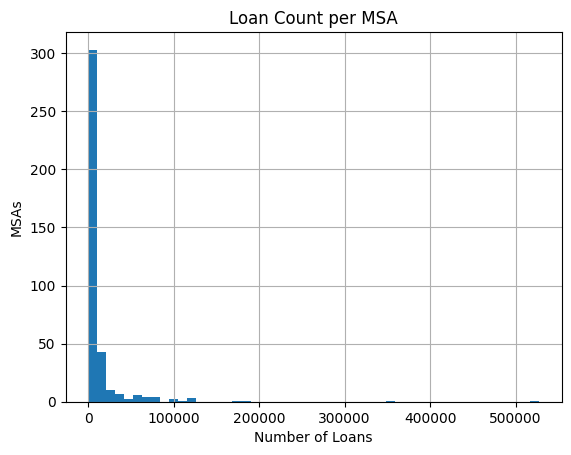

In [3]:

msa_counts = df['Metropolitan Statistical Area'].value_counts()

# Quick stats
print(msa_counts.describe())

# Find MSAs with < 30 loans
low_coverage = msa_counts[msa_counts < 30]
print(f"MSAs with <30 loans: {len(low_coverage)}")

# Visualize distribution
import matplotlib.pyplot as plt
msa_counts.hist(bins=50)
plt.title("Loan Count per MSA")
plt.xlabel("Number of Loans")
plt.ylabel("MSAs")
plt.show()

In [5]:
pd.set_option('display.max_columns', None)
df.head(2)

,Loan Number,Acquisition Date,Note Date,Maturity Date at Acquisition,Loan Acquisition UPB,Amortization Type,Interest Type,Loan Product Type,Original UPB,Amortization Term,Original Interest Rate,Lien Position,Transaction ID,Issue Date,Loan Acquisition LTV,Underwritten DSCR,Underwritten DSCR Type,Original Term,Original I/O Term,I/O End Date,Loan Ever 60+ Days Delinquent,Loss Sharing Type,Modified Loss Sharing Percentage,Number of Properties at Acquisition,Property Acquisition Total Unit Count,Specific Property Type,Year Built,Property City,Property State,Property Zip Code,Metropolitan Statistical Area,Physical Occupancy %,Liquidation/Prepayment Code,Liquidation/Prepayment Date,Foreclosure Date,Credit Event Date,Foreclosure Value,Lifetime Net Credit Loss Amount,Sale Price,Default Amount,Credit Event Type,Reporting Period Date,Loan Active Property Count,Note Rate,Maturity Date - Current,UPB - Current,Delinquency UPB,Loan Payment Status,SDQ Indicator,Most Recent Modification Date,Modification Indicator,Defeasance Date,Prepayment Provision,Prepayment Provision End Date,Affordable Housing Type,MCIRT Deal ID,MCAS Deal ID,DUS Prepayment Outcomes,DUS Prepayment Segments,Loan Age,Green Bond Indicator,Social Bond Indicator,start,stop,state,event_time
0,1673867584,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,"$14,736,000.00",360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-01-01,1.0,7.65,2009-12-01,"$14,725,385.83",NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,0,1,Current,NaN
1,1673867584,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,"$14,736,000.00",360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-02-01,1.0,7.65,2009-12-01,"$14,714,704.00",NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,1,2,Current,NaN


In [7]:
df['Interest Type'].value_counts()

Interest Type
Fixed    4598276
ARM       324517
Name: count, dtype: int64

In [96]:
# Making age column
df['Age'] = df['start']

In [97]:
# Making next state column
df = df.sort_values(by=['Loan Number', 'start'])
df['next_state'] = df.groupby('Loan Number')['state'].shift(-1)
df['next_state'] = df['next_state'].fillna(df['state'])

In [98]:
# Making proportion through loan column
df['Note Date'] = pd.to_datetime(df['Note Date'], errors='coerce')
df['Maturity Date at Acquisition'] = pd.to_datetime(df['Maturity Date at Acquisition'], errors='coerce')
df['Reporting Period Date'] = pd.to_datetime(df['Reporting Period Date'], errors='coerce')


def month_diff(start, end):
    return (end.dt.year - start.dt.year) * 12 + (end.dt.month - start.dt.month)


df['Original Term (Months)'] = month_diff(df['Note Date'], df['Maturity Date at Acquisition'])

df['Months Into Loan'] = month_diff(df['Note Date'], df['Reporting Period Date'])
df['Proportion Through Loan'] = df['Months Into Loan'] / df['Original Term (Months)']
df['Proportion Through Loan'] = df['Proportion Through Loan'].clip(lower=0, upper=1)

In [99]:
df.head()

,Loan Number,Acquisition Date,Note Date,Maturity Date at Acquisition,Loan Acquisition UPB,Amortization Type,Interest Type,Loan Product Type,Original UPB,Amortization Term,Original Interest Rate,Lien Position,Transaction ID,Issue Date,Loan Acquisition LTV,Underwritten DSCR,Underwritten DSCR Type,Original Term,Original I/O Term,I/O End Date,Loan Ever 60+ Days Delinquent,Loss Sharing Type,Modified Loss Sharing Percentage,Number of Properties at Acquisition,Property Acquisition Total Unit Count,Specific Property Type,Year Built,Property City,Property State,Property Zip Code,Metropolitan Statistical Area,Physical Occupancy %,Liquidation/Prepayment Code,Liquidation/Prepayment Date,Foreclosure Date,Credit Event Date,Foreclosure Value,Lifetime Net Credit Loss Amount,Sale Price,Default Amount,Credit Event Type,Reporting Period Date,Loan Active Property Count,Note Rate,Maturity Date - Current,UPB - Current,Delinquency UPB,Loan Payment Status,SDQ Indicator,Most Recent Modification Date,Modification Indicator,Defeasance Date,Prepayment Provision,Prepayment Provision End Date,Affordable Housing Type,MCIRT Deal ID,MCAS Deal ID,DUS Prepayment Outcomes,DUS Prepayment Segments,Loan Age,Green Bond Indicator,Social Bond Indicator,start,stop,state,event_time,Age,next_state,Original Term (Months),Months Into Loan,Proportion Through Loan
0,1673867584,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,"$14,736,000.00",360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-01-01,1.0,7.65,2009-12-01,"$14,725,385.83",NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,0,1,Current,NaN,0,Current,121,2,0.016529
1,1673867584,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,"$14,736,000.00",360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-02-01,1.0,7.65,2009-12-01,"$14,714,704.00",NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,1,2,Current,NaN,1,Current,121,3,0.024793
2,1673867584,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,"$14,736,000.00",360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-03-01,1.0,7.65,2009-12-01,"$14,703,954.09",NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,2,3,Current,NaN,2,Current,121,4,0.033058
3,1673867584,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,"$14,736,000.00",360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-04-01,1.0,7.65,2009-12-01,"$14,693,135.65",NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,3,4,Current,NaN,3,Current,121,5,0.041322
4,1673867584,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,"$14,736,000.00",360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-05-01,1.0,7.65,2009-12-01,"$14,682,248.26",NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,4,5

In [100]:
# Renaming columns & Reordering
df = df.rename(columns={'start': 'Start', 'stop': 'Stop', 'state': 'State', 'next_state': 'Next State'})

new_order = ['Loan Number', 'Start', 'Stop', 'Age', 'State', 'Next State', 'Acquisition Date',
       'Note Date', 'Maturity Date at Acquisition', 'Loan Acquisition UPB',
       'Amortization Type', 'Interest Type', 'Loan Product Type',
       'Original UPB', 'Amortization Term', 'Original Interest Rate',
       'Lien Position', 'Transaction ID ', 'Issue Date',
       'Loan Acquisition LTV', 'Underwritten DSCR', 'Underwritten DSCR Type',
       'Original Term', 'Original I/O Term', 'I/O End Date',
       'Loan Ever 60+ Days Delinquent', 'Loss Sharing Type',
       'Modified Loss Sharing Percentage',
       'Number of Properties at Acquisition',
       'Property Acquisition Total Unit Count', 'Specific Property Type',
       'Year Built', 'Property City', 'Property State', 'Property Zip Code',
       'Metropolitan Statistical Area', 'Physical Occupancy %',
       'Liquidation/Prepayment Code', 'Liquidation/Prepayment Date',
       'Foreclosure Date', 'Credit Event Date', 'Foreclosure Value',
       'Lifetime Net Credit Loss Amount', 'Sale Price', 'Default Amount',
       'Credit Event Type', 'Reporting Period Date',
       'Loan Active Property Count', 'Note Rate', 'Maturity Date - Current',
       'UPB - Current', 'Delinquency UPB', 'Loan Payment Status',
       'SDQ Indicator', 'Most Recent Modification Date',
       'Modification Indicator', 'Defeasance Date', 'Prepayment Provision',
       'Prepayment Provision End Date', 'Affordable Housing Type',
       'MCIRT Deal ID', 'MCAS Deal ID', 'DUS Prepayment Outcomes',
       'DUS Prepayment Segments', 'Loan Age', 'Green Bond Indicator',
       'Social Bond Indicator',  'event_time', 'Proportion Through Loan']
df = df[new_order]

In [101]:
df['Amortization Type'].value_counts(dropna=False)

Amortization Type
Amortizing Balloon                  2663793
Interest Only/Amortizing/Balloon    1349727
Interest Only/Balloon                614908
Fully Amortizing                     291909
Interest Only/Fully Amortizing         2456
Name: count, dtype: int64

In [102]:
df['Amortization Type Encoded'], mapping = pd.factorize(df['Amortization Type'])
print(dict(enumerate(mapping)))

{0: 'Amortizing Balloon', 1: 'Fully Amortizing', 2: 'Interest Only/Balloon', 3: 'Interest Only/Amortizing/Balloon', 4: 'Interest Only/Fully Amortizing'}


In [103]:
df['Interest Type Encoded'], mapping = pd.factorize(df['Interest Type'])
print(dict(enumerate(mapping)))

{0: 'Fixed', 1: 'ARM'}


In [104]:
# Turning states into numbers so the model can output them later on
le_state = LabelEncoder()
df['State_Encoded'] = le_state.fit_transform(df['State'])
df['Next_State_Encoded'] = le_state.transform(df['Next State'])

In [105]:
# Numericizing columns to be features 
df['Original UPB'] = (
    df['Original UPB']
    .str.replace('[\$,]', '', regex=True)  # remove $ and commas
    .astype(float)
)
df['UPB - Current'] = (
    df['UPB - Current']
    .str.replace('[\$,]', '', regex=True)  # remove $ and commas
    .astype(float)
)
df['Note Rate'] = df['Note Rate'].astype(float)
df['Original Interest Rate'] = df['Original Interest Rate'].astype(float)
df['Underwritten DSCR'] = df['Underwritten DSCR'].astype(float)
df['Original Term'] = df['Original Term'].astype(float)
df['Loan Acquisition LTV'] = df['Loan Acquisition LTV'].astype(float)

<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:9: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:9: SyntaxWarning: invalid escape sequence '\$'
C:\Users\samvi\AppData\Local\Temp\ipykernel_40768\1330290218.py:4: SyntaxWarning: invalid escape sequence '\$'
  .str.replace('[\$,]', '', regex=True)  # remove $ and commas
C:\Users\samvi\AppData\Local\Temp\ipykernel_40768\1330290218.py:9: SyntaxWarning: invalid escape sequence '\$'
  .str.replace('[\$,]', '', regex=True)  # remove $ and commas


In [106]:
# Making a bunch of columns 

df['Percentage Paid'] = np.where(
    df['Original UPB'].notna() & (df['Original UPB'] != 0),
    (df['Original UPB'] - df['UPB - Current']) / df['Original UPB'],
    np.nan
)

df['Paid per Age'] = np.where(
    df['Age'].notna() & (df['Age'] != 0),
    df['Percentage Paid'] / df['Age'],
    0  # or np.nan if you prefer to keep it missing
)
df['Original Term'] = pd.to_numeric(df['Original Term'], errors='coerce')
df['Original I/O Term'] = pd.to_numeric(df['Original I/O Term'], errors='coerce')

df['Reporting Period Date'] = pd.to_datetime(df['Reporting Period Date'], errors='coerce')
df['Prepayment Provision End Date'] = pd.to_datetime(df['Prepayment Provision End Date'], errors='coerce')


df['LTV_over_DSCR'] = np.where(
    df['Loan Acquisition LTV'].notna() & df['Underwritten DSCR'].notna() & (df['Underwritten DSCR'] != 0),
    df['Loan Acquisition LTV'] / df['Underwritten DSCR'],
    np.nan
)

df['NoteRate_over_DSCR'] = np.where(
    df['Original Interest Rate'].notna() & df['Underwritten DSCR'].notna() & (df['Underwritten DSCR'] != 0),
    df['Original Interest Rate'] / df['Underwritten DSCR'],
    np.nan  # or 0 if you prefer
)

df['Current_LTV_Approx'] = np.where(
    df['Original UPB'].notna() & df['Loan Acquisition LTV'].notna() & (df['Loan Acquisition LTV'] != 0) & df['UPB - Current'].notna(),
    df['UPB - Current'] / (df['Original UPB'] / df['Loan Acquisition LTV']),
    np.nan
)

df['LTV_times_DSCR'] = np.where(
    df['Loan Acquisition LTV'].notna() & df['Underwritten DSCR'].notna(),
    df['Loan Acquisition LTV'] * df['Underwritten DSCR'],
    np.nan
)

C:\Users\samvi\AppData\Local\Temp\ipykernel_40768\2792579069.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Prepayment Provision End Date'] = pd.to_datetime(df['Prepayment Provision End Date'], errors='coerce')


In [107]:
'''
#Downsampling current loans 
risky_loans = df[df['State'].isin(['Default', 'Foreclosure'])]['Loan Number'].unique()
all_loans = df['Loan Number'].unique()
safe_loans = np.setdiff1d(all_loans, risky_loans)
np.random.seed(42)  # for reproducibility
loans_to_drop = np.random.choice(safe_loans, size=int(0.5 * len(safe_loans)), replace=False)
df_filtered = df[~df['Loan Number'].isin(loans_to_drop)]
'''

"\n#Downsampling current loans \nrisky_loans = df[df['State'].isin(['Default', 'Foreclosure'])]['Loan Number'].unique()\nall_loans = df['Loan Number'].unique()\nsafe_loans = np.setdiff1d(all_loans, risky_loans)\nnp.random.seed(42)  # for reproducibility\nloans_to_drop = np.random.choice(safe_loans, size=int(0.5 * len(safe_loans)), replace=False)\ndf_filtered = df[~df['Loan Number'].isin(loans_to_drop)]\n"

In [108]:
# Choosing features & targets 
feature_cols = ['State_Encoded', 'Age', 'Original UPB', 'UPB - Current', 'Note Rate', 'Underwritten DSCR', 
                'Original Term', 'Loan Acquisition LTV', 'Proportion Through Loan', 'Amortization Type Encoded', 
                'Interest Type Encoded', 'Percentage Paid', 'Paid per Age', 
                'LTV_over_DSCR', 'NoteRate_over_DSCR', 'Current_LTV_Approx', 'LTV_times_DSCR']

# 'State_Encoded', 

# Create X and y
X = df[feature_cols]
y = df['Next_State_Encoded']

In [109]:
# Choosing some random loans to make the model - reduces size for testing purposes
random_loans = df['Loan Number'].dropna().unique()
random_loans = pd.Series(random_loans).sample(n=750, random_state=42)  # optional random_state for reproducibility
df_random = df[df['Loan Number'].isin(random_loans)]
df = df_random

In [110]:
# Creating Train Test Split for testing purposes
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # ensures class balance in both sets
)

In [111]:
# Training the model

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train) #Punishing for getting wrong the more rare classes


model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=-1,
    max_depth=6,             # ↓ slightly, avoids overfitting rare paths
    n_estimators=700,        # ↑ if using lower learning rate
    learning_rate=0.05,      # ↓ improves generalization
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,                 # ↑ only split if meaningful gain
    min_child_weight=10      # ↑ avoids overfitting noisy splits
)
'''

model = XGBClassifier(
    objective='multi:softprob',  # returns full probability distribution
    num_class=len(y.unique()),   # number of distinct loan states
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=-1                    # parallel training
)
'''
print(type(sample_weights))
print(sample_weights.shape if hasattr(sample_weights, 'shape') else len(sample_weights))
print(sample_weights[:5])

model.fit(X_train, y_train, sample_weight=sample_weights)

<class 'numpy.ndarray'>
(3938234,)
[0.20420879 0.20420879 0.20420879 0.20420879 0.20420879]


c:\Users\samvi\Documents\Coding Projects\Embedded Work\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:58:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=700, n_jobs=-1, num_class=5, ...)

In [ ]:
'''
joblib.dump(model, 'xgb_model.pkl')

# Check file size
model_size = os.path.getsize('xgb_model.pkl') / (1024 * 1024)  # in megabytes
print(f"Model size: {model_size:.2f} MB")
'''

Model size: 12.34 MB


In [112]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le_state.classes_))

                     precision    recall  f1-score   support

            Current       1.00      0.90      0.95    964267
            Default       0.57      0.82      0.67      4284
        Foreclosure       0.40      0.55      0.46       257
Fully Paid, Matured       0.52      0.96      0.68      1411
Fully Paid, Prepaid       0.11      0.77      0.19     14340

           accuracy                           0.90    984559
          macro avg       0.52      0.80      0.59    984559
       weighted avg       0.98      0.90      0.94    984559



In [113]:
model.feature_importances_

array([0.68796384, 0.0278229 , 0.00822499, 0.00910282, 0.01334585,
       0.00898592, 0.02424131, 0.0114083 , 0.09457045, 0.00922233,
       0.02330907, 0.01528231, 0.01110601, 0.0126946 , 0.0198765 ,
       0.0133504 , 0.00949242], dtype=float32)

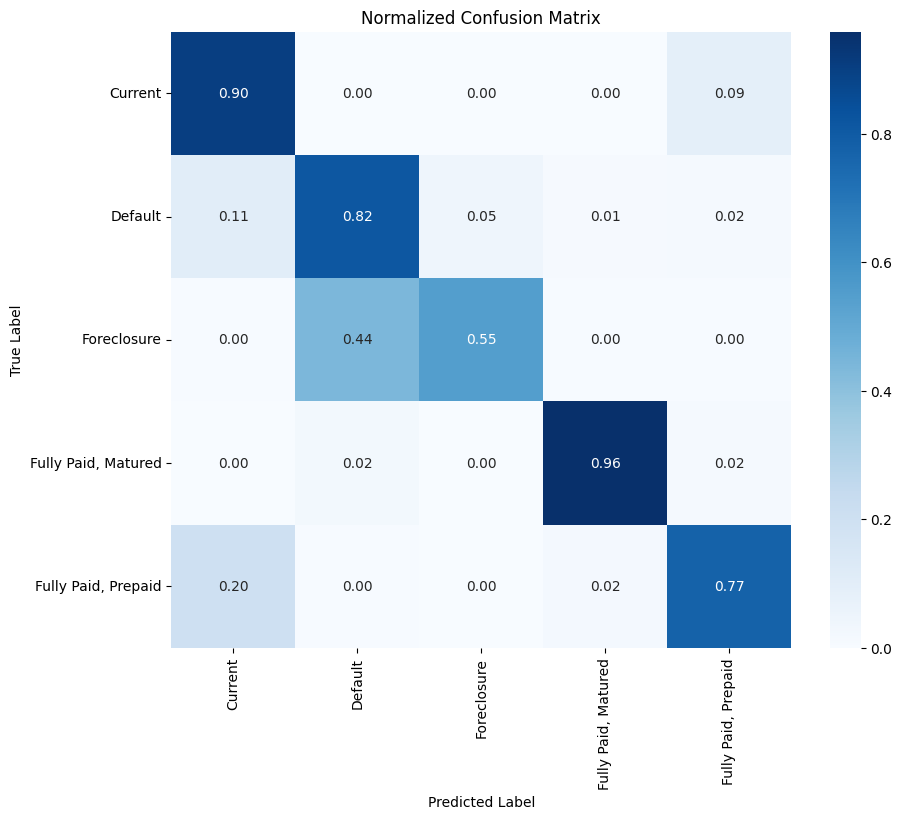

Classification Report:
                     precision  recall  f1-score     support
Current                  0.996   0.904     0.948  964267.000
Default                  0.572   0.816     0.672    4284.000
Foreclosure              0.398   0.549     0.462     257.000
Fully Paid, Matured      0.524   0.959     0.678    1411.000
Fully Paid, Prepaid      0.110   0.775     0.193   14340.000
accuracy                 0.901   0.901     0.901       0.901
macro avg                0.520   0.800     0.591  984559.000
weighted avg             0.981   0.901     0.935  984559.000


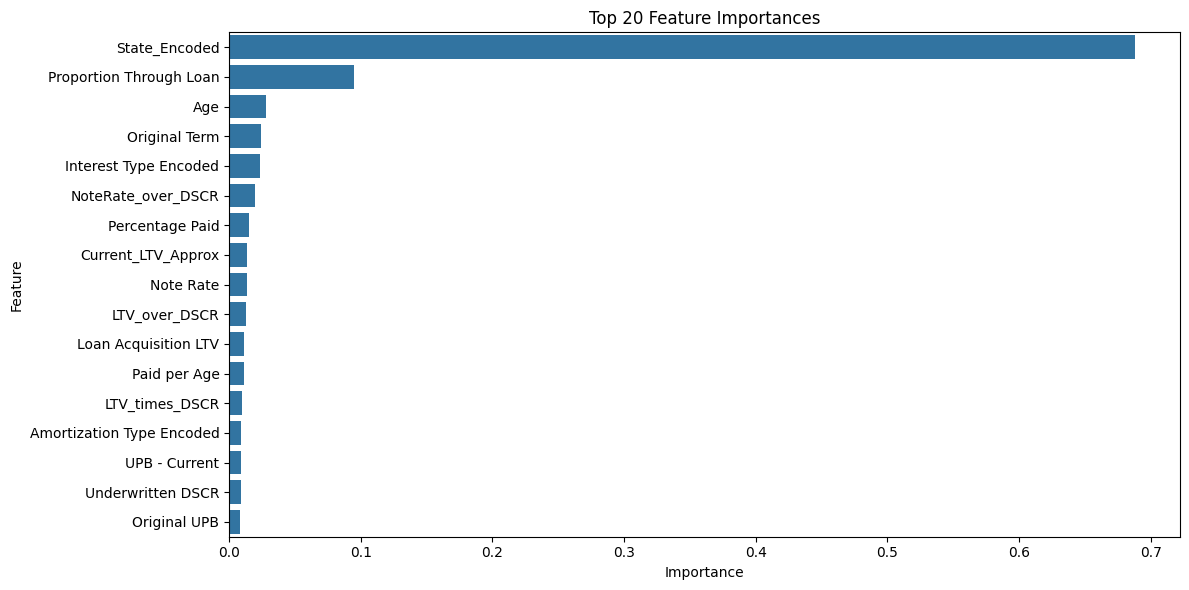

In [114]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=le_state.classes_, yticklabels=le_state.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

# 2. Classification Report
report = classification_report(y_test, y_pred, target_names=le_state.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("Classification Report:")
print(report_df.round(3))

# 3. Feature Importance Plot
importances = model.feature_importances_
features = X.columns
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feat_imp_df.head(20), x='Importance', y='Feature')
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# 4. Transition-level Accuracy Matrix (if you have State and Next State columns in your dataset)
# Optional: if you originally had these columns for each row
if 'State' in X_test.columns and 'Next State' in y_test.index.names:
    actual_transitions = pd.DataFrame({
        'State': X_test['State'].values,
        'Next State True': le_state.inverse_transform(y_test),
        'Next State Pred': le_state.inverse_transform(y_pred)
    })

    trans_summary = actual_transitions.groupby(['State', 'Next State True']).size().reset_index(name='Total')
    trans_correct = actual_transitions[actual_transitions['Next State True'] == actual_transitions['Next State Pred']]
    trans_correct_summary = trans_correct.groupby(['State', 'Next State True']).size().reset_index(name='Correct')

    merged = pd.merge(trans_summary, trans_correct_summary, on=['State', 'Next State True'], how='left')
    merged['Correct'] = merged['Correct'].fillna(0)
    merged['Accuracy'] = merged['Correct'] / merged['Total']

    # Pivot to heatmap
    matrix = merged.pivot(index='State', columns='Next State True', values='Accuracy')
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("Transition Prediction Accuracy by State to Next State")
    plt.xlabel("True Next State")
    plt.ylabel("Current State")
    plt.show()

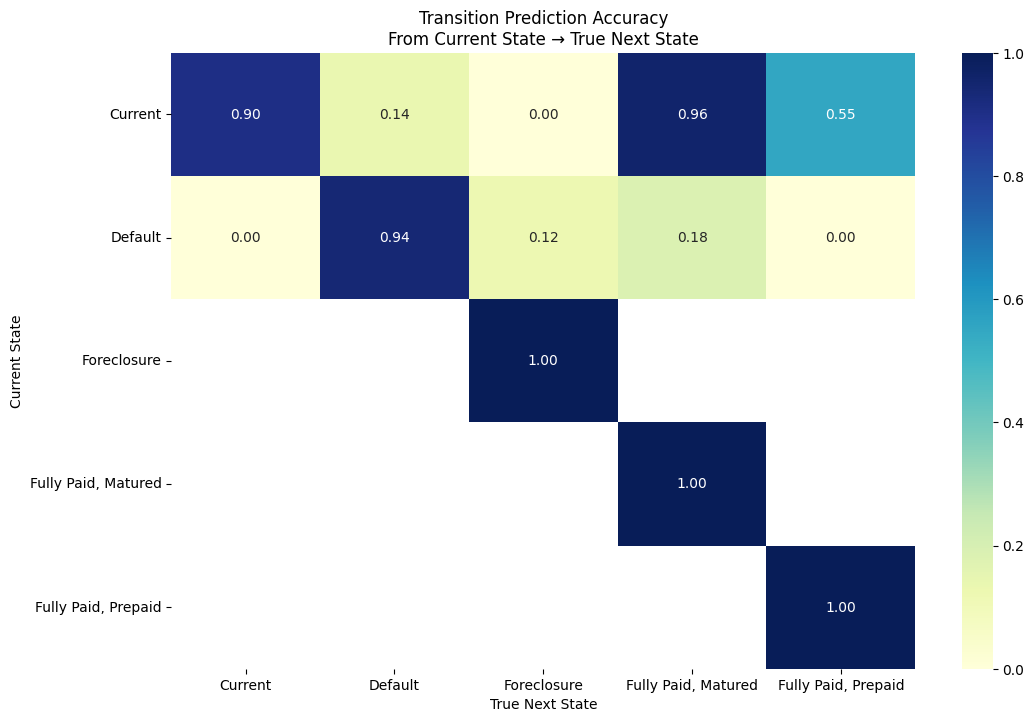

In [115]:
# Map encoded values back to strings
from_state = le_state.inverse_transform(X_test['State_Encoded'])
true_next = le_state.inverse_transform(y_test)
pred_next = le_state.inverse_transform(y_pred)

# Create a DataFrame of transitions
df_trans = pd.DataFrame({
    'From': from_state,
    'TrueNext': true_next,
    'PredNext': pred_next
})

# Total transitions by true path
totals = df_trans.groupby(['From', 'TrueNext']).size().reset_index(name='Total')

# Correct predictions (true == predicted)
corrects = df_trans[df_trans['TrueNext'] == df_trans['PredNext']]\
    .groupby(['From', 'TrueNext']).size().reset_index(name='Correct')

# Merge and calculate accuracy
merged = pd.merge(totals, corrects, on=['From', 'TrueNext'], how='left')
merged['Correct'] = merged['Correct'].fillna(0)
merged['Accuracy'] = merged['Correct'] / merged['Total']

# Pivot to matrix
matrix = merged.pivot(index='From', columns='TrueNext', values='Accuracy')


plt.figure(figsize=(12, 8))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Transition Prediction Accuracy\nFrom Current State → True Next State")
plt.xlabel("True Next State")
plt.ylabel("Current State")
plt.show()

# OLD

In [40]:
cm = confusion_matrix(y_test, y_pred)

# Create a labeled DataFrame for better readability
cm_df = pd.DataFrame(cm, index=le_state.classes_, columns=le_state.classes_)

print("Transition Matrix (Confusion Matrix):")
print(tabulate(cm_df, headers='keys', tablefmt='pretty'))

Transition Matrix (Confusion Matrix):
+---------------------+---------+---------+-------------+---------------------+---------------------+
|                     | Current | Default | Foreclosure | Fully Paid, Matured | Fully Paid, Prepaid |
+---------------------+---------+---------+-------------+---------------------+---------------------+
|       Current       | 867052  |  3431   |     30      |         955         |        92799        |
|       Default       |   478   |  3346   |     314     |         77          |         69          |
|     Foreclosure     |    2    |   94    |     161     |          0          |          0          |
| Fully Paid, Matured |    2    |   37    |      1      |        1359         |         12          |
| Fully Paid, Prepaid |  2886   |   79    |      0      |         329         |        11046        |
+---------------------+---------+---------+-------------+---------------------+---------------------+


In [91]:
def analyze_transition_accuracy(y_test, y_pred, label_encoder):
    # Extract class labels
    labels = label_encoder.classes_

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=range(len(labels)))
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    print("📊 Transition Matrix (Confusion Matrix):")
    print(cm_df)
    print("\n")

    # 2. Accuracy per Actual State
    print("🔍 Accuracy per Actual State:")
    for state in labels:
        correct = cm_df.loc[state, state]
        total = cm_df.loc[state].sum()
        accuracy = correct / total if total > 0 else 0
        print(f"{state:25} → Accuracy: {accuracy:.2%} (correct: {correct:,} / total: {total:,})")

    print("\n")

    # 3. Top Misclassified Transitions
    print("🔻 Top Misclassified Transitions (Off-Diagonal Errors):")
    errors = []
    for actual in labels:
        for predicted in labels:
            if actual != predicted:
                count = cm_df.loc[actual, predicted]
                if count > 0:
                    errors.append((actual, predicted, count))

    errors.sort(key=lambda x: x[2], reverse=True)

    for actual, predicted, count in errors[:10]:
        print(f"{actual:25} → {predicted:25}: {count:,} cases")

    print("\n")

    # 4. Normalized Confusion Matrix (Optional)
    cm_norm = cm_df.div(cm_df.sum(axis=1), axis=0).round(3)
    print("📈 Normalized Transition Matrix (row-wise %):")
    print(cm_norm)

    return cm_df, cm_norm  # for later plotting if needed

cm_df, cm_norm = analyze_transition_accuracy(y_test, y_pred, le_state)

📊 Transition Matrix (Confusion Matrix):
                     Current  Default  Foreclosure  Fully Paid, Matured  \
Current               962790      397            0                  350   
Default                  730     3459           52                   27   
Foreclosure                4      127          126                    0   
Fully Paid, Matured      512       29            1                  847   
Fully Paid, Prepaid     6860       50            0                   26   

                     Fully Paid, Prepaid  
Current                              730  
Default                               16  
Foreclosure                            0  
Fully Paid, Matured                   22  
Fully Paid, Prepaid                 7404  


🔍 Accuracy per Actual State:
Current                   → Accuracy: 99.85% (correct: 962,790 / total: 964,267)
Default                   → Accuracy: 80.74% (correct: 3,459 / total: 4,284)
Foreclosure               → Accuracy: 49.03% (correct: 126 / t

In [26]:
sample = X_test.iloc[0:1]  # Get the first row as a DataFrame
probs = model.predict_proba(sample)[0]  # 1D array of probabilities
transition_probs = dict(zip(le_state.classes_, probs))
print(transition_probs)

{'Current': np.float32(0.9997619), 'Default': np.float32(5.1527753e-05), 'Foreclosure': np.float32(1.1493723e-07), 'Fully Paid, Matured': np.float32(3.8771216e-08), 'Fully Paid, Prepaid': np.float32(0.00018649068)}


In [2]:
model = joblib.load('xgb_model.pkl')